# 06 Transfer Learning

In [13]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import requests
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from torchinfo import summary
import torch
from torch import nn
from torchmetrics import Accuracy, ConfusionMatrix
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
import zipfile



## setup

In [3]:
# get the code files and data directories
from going_modular import data_loaders, engine, hassan_TinyVGG, utils
data_path = Path('../data')
image_path = data_path/'pizza_steak_sushi_20_percent'
# train_dir = '../data/pizza_steak_sushi_20_percent/train'
# test_dir = '../data/pizza_steak_sushi_20_percent/test'
train_dir = image_path /'train'
test_dir = image_path/ 'test'

## create dataloader

In [4]:
manual_transforms = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 456, 0.406],
                         std=[0.229, 224, 0.225])

])

In [6]:
train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1550ec88090>,
 ['pizza', 'steak', 'sushi'])

## get pretrained model

In [18]:
# get weithgs
device = "cuda" if torch.cuda.is_available() else "cpu"
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
train_dataloader, test_dataloader, class_names = data_loaders.create_dataloaders(train_dir = train_dir,
                                                                                 test_dir = test_dir,
                                                                                 transform=auto_transforms,
                                                                                 batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1550ec92a10>,
 ['pizza', 'steak', 'sushi'])

In [14]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0
torchvision version: 0.18.0


In [21]:
# get summary
summary (model = model,
         input_size = (1, 3, 2224, 224),
         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
         col_width = 20,
        row_settings =['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 2224, 224]    [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 2224, 224]    [1, 1280, 70, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 2224, 224]    [1, 32, 1112, 112]   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 2224, 224]    [1, 32, 1112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 1112, 112]   [1, 32, 1112, 112]   64                   True
│    │    └─SiLU (2)                                         [1, 32, 1112, 112]   [1, 32, 1112, 112]   --                   --
│    └─Sequential (1)                                        [1, 32, 1112, 112]   [1, 16, 1112

In [26]:
# freeze parameter
for param in model.features.parameters():
  param.requires_grad = False 


In [27]:
summary (model = model,
         input_size = (1, 3, 2224, 224),
         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
         col_width = 20,
        row_settings =['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 2224, 224]    [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 2224, 224]    [1, 1280, 70, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 2224, 224]    [1, 32, 1112, 112]   --                   False
│    │    └─Conv2d (0)                                       [1, 3, 2224, 224]    [1, 32, 1112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 1112, 112]   [1, 32, 1112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 1112, 112]   [1, 32, 1112, 112]   --                   --
│    └─Sequential (1)                                        [1, 32, 1112, 112]   [1, 1

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = len (class_names)
model.classifier= torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features = 1280,
                    out_features = output_shape,
                    bias = True)
).to(device)

## 4. Train model

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)



In [45]:
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = engine.train_model(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn = loss_fn,
                       epochs = 20,
                       device = device)

end_time = timer ()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  5%|▌         | 1/20 [00:04<01:24,  4.44s/it]

Epoch: 1 |train_loss: 0.6304 |train_acc:0.8396 | test_loss: 0.6039 | test_acc: 0.8540


 55%|█████▌    | 11/20 [00:50<00:42,  4.74s/it]

Epoch: 11 |train_loss: 0.5530 |train_acc:0.8583 | test_loss: 0.5144 | test_acc: 0.8909


100%|██████████| 20/20 [01:32<00:00,  4.63s/it]

[INFO] Total training time: 92.601 seconds


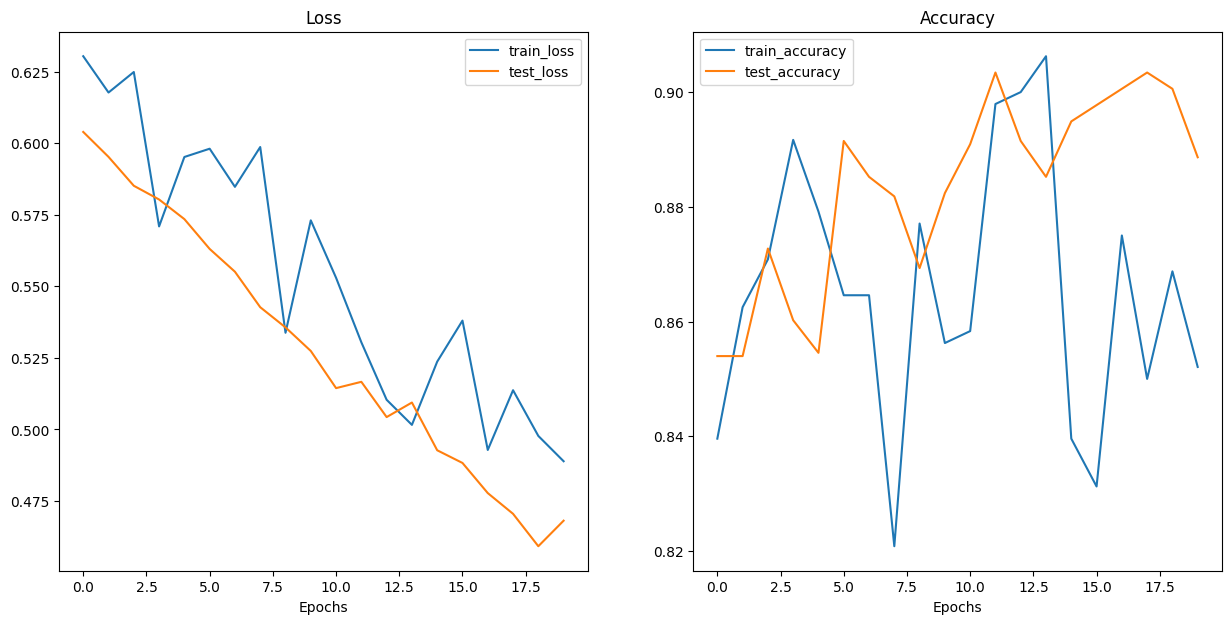

In [46]:
# plot plot_loss_cures
from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 6. Make Predictions

In [61]:
def pred_and_plot_image (model: torch.nn.Module,
                         image_path: str,
                         class_names: List[str],
                         image_size: Tuple[int, int] = (224, 22),
                         transform: torchvision.transforms = None,
                         device: torch.device = device):
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize (mean = [0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
        ])
    
    model.to(device)

    model.eval()
    
    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0)


        target_image_pred = model(transformed_image.to(device))

        target_image_pred = model (transformed_image.to(device))

    target_iamge_pred_probs = torch.softmax(target_image_pred, dim = 1)

    target_image_pred_label = torch.argmax(target_iamge_pred_probs, dim = 1)

    plt.figure ()
    plt.imshow(img)
    plt.title (f'Pred: {class_names[target_image_pred_label]} | Prob: {target_iamge_pred_probs.max():.3f}')
    plt.axis(False)

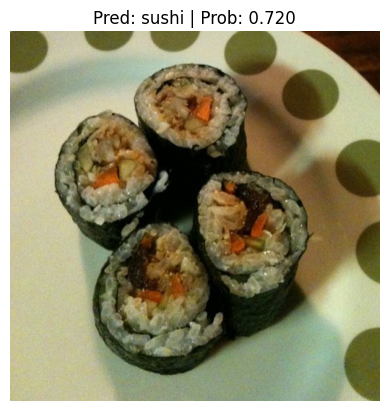

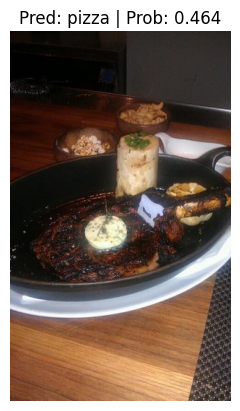

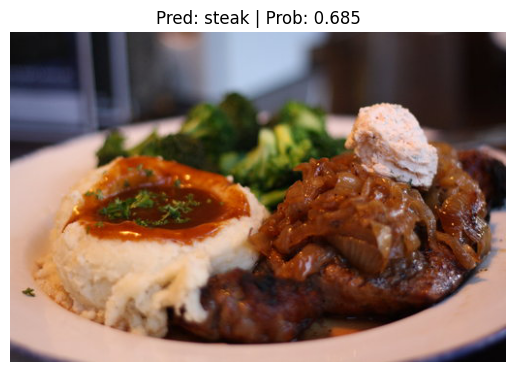

In [62]:
# plot image
num_images_to_plot = 3
test_image_path_list = list (Path(test_dir).glob ('*/*.jpg'))
test_image_path_sample = random.sample (population=test_image_path_list,
                                        k = num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image (model = model,
                         image_path=image_path,
                         class_names=class_names,
                         image_size = (224, 224))

downloading iamage


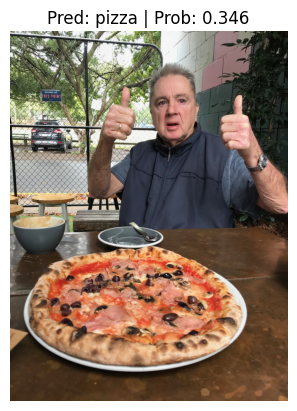

In [63]:
# custome image plot
custom_image_path = data_path /'04-pizza-dad.jpg'

if not custom_image_path.is_file():

    with open(custom_image_path, 'wb') as f:
        request = requests.get ("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print ('downloading iamage')
        f.write(request.content)
else:
        print('image eixist')

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names = class_names)
